In [18]:
# https://www.kaggle.com/c/demand-forecasting-kernels-only?fbclid=IwAR3v_NHNYSUxLHDhkN-qEl_3vot0JNi9jWBCyPaqcr4M13ag1AyDVpPatZU
import pandas as pd
import numpy as np
import statistics as st
import sklearn
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import preprocessing
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import pylab
import re
%matplotlib inline 

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 50 different items at 10 different stores.

In [3]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [5]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


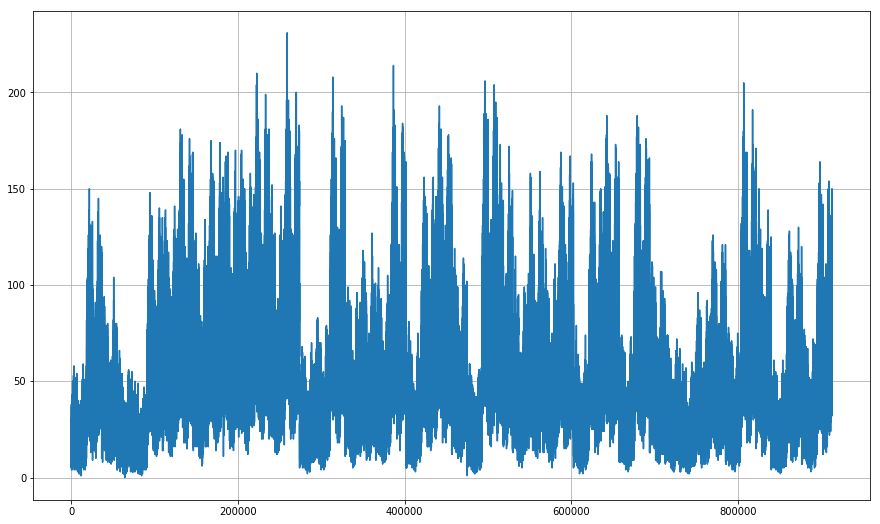

In [8]:
import matplotlib.pyplot as plt  
%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
train["sales"].plot(grid = True) # Plot the adjusted closing price of AAPL


In [9]:
train.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [10]:
train['sales'].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

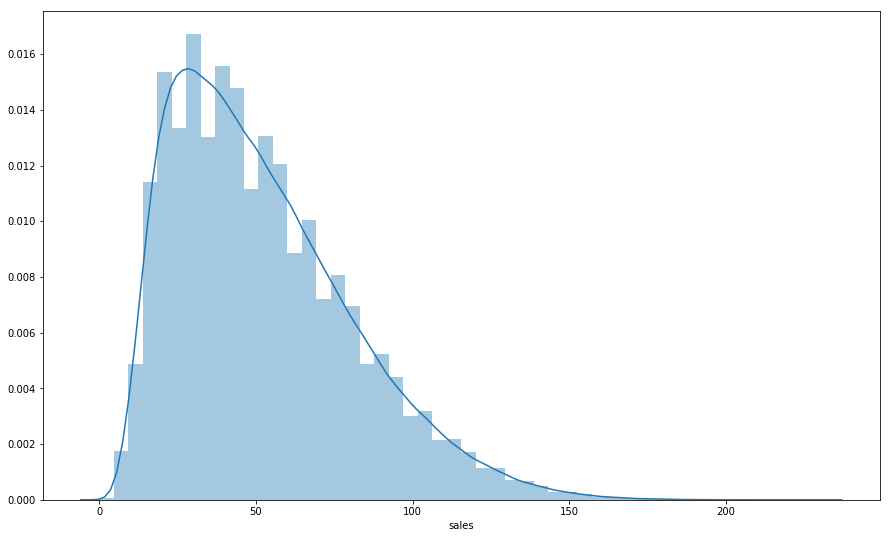

In [11]:
sns.distplot(train["sales"])

In [12]:
train['store'].describe()

count    913000.000000
mean          5.500000
std           2.872283
min           1.000000
25%           3.000000
50%           5.500000
75%           8.000000
max          10.000000
Name: store, dtype: float64

# Correlation

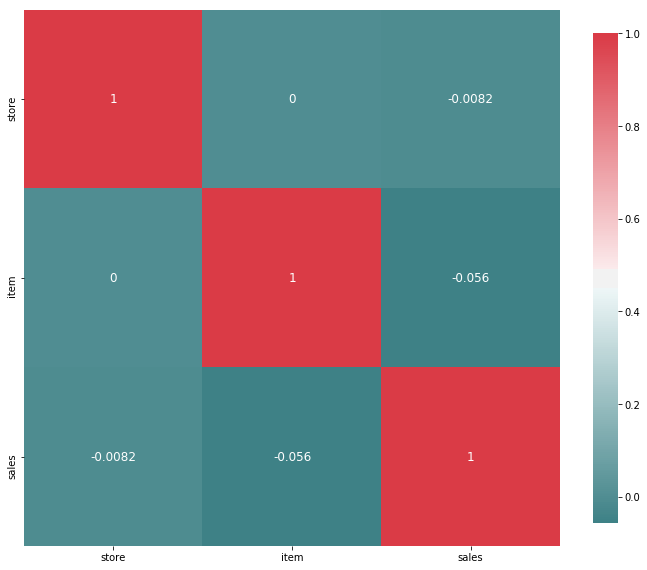

In [13]:
def plot_correlation_map(df):
    corr = df.corr()
    _, ax = plt.subplots(figsize=(12, 10))
    cmap = sns.diverging_palette(200, 10, as_cmap=True)
    _ = sns.heatmap(
        corr,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize': 12}
    )
    
plot_correlation_map(train)

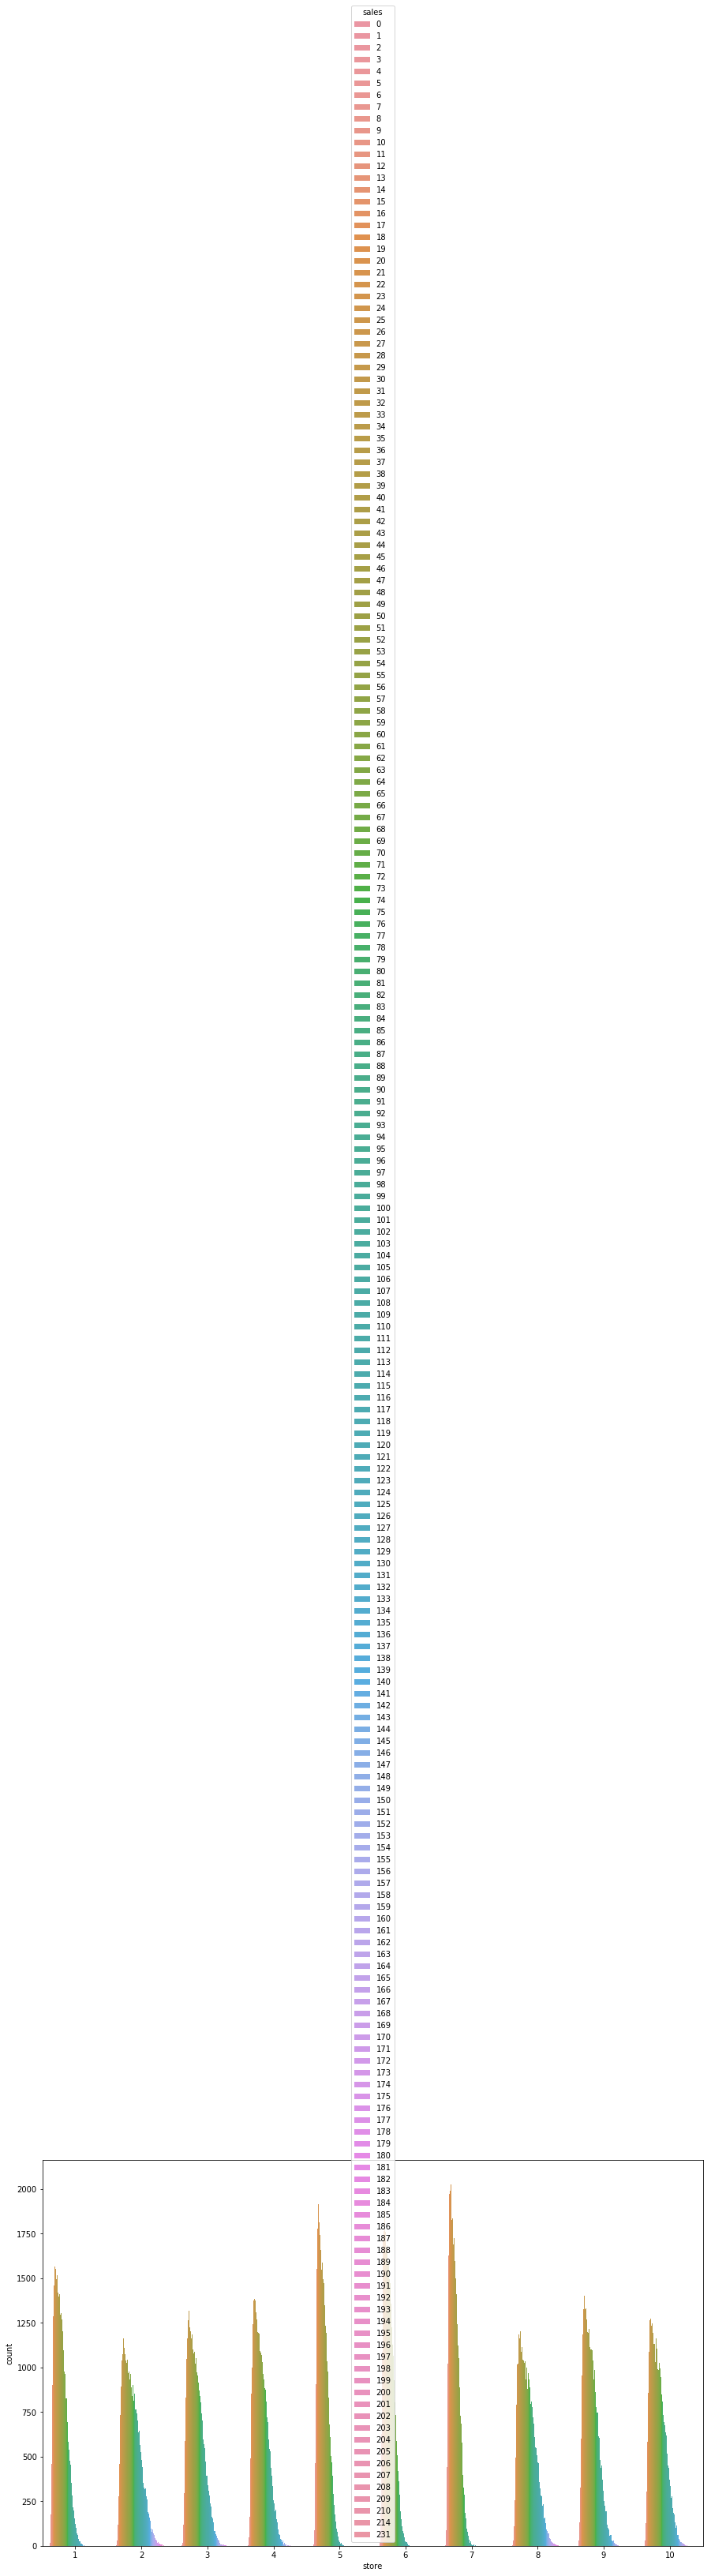

In [14]:
sns.countplot('store', data=train, hue='sales')

# Classify by store

In [15]:
def store_classification(store_dt, sale):
    sale_list = []
    
    for i in range(1,11):
        sales = 0
        num = 0
        
        for store in store_dt:
            if store == i:
                sales += sale[num]
            num += 1
            
        sale_list.append(sales)
            
    return sale_list

In [16]:
store_classification(train['store'], train['sales'])

[4315603,
 6120128,
 5435144,
 5012639,
 3631016,
 3627670,
 3320009,
 5856169,
 5025976,
 5360158]

<BarContainer object of 10 artists>

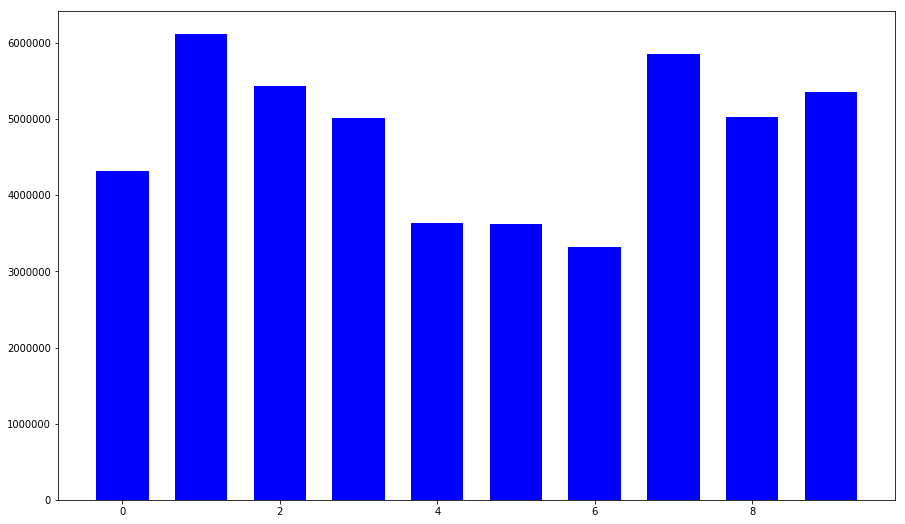

In [17]:
# 店ごとの売り上げ

import plotly.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt


y = store_classification(train['store'], train['sales'])
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width, color="blue")

# Lets view couple of dicing versions of the table..
### 1.store Vs item Vs date :

### pandasのピボットテーブルでカテゴリ毎の統計量などを算出 (https://note.nkmk.me/python-pandas-pivot-table/)

In [26]:
train_table_store_item_date = pd.pivot_table(train, index=['store'], columns=['item', 'date'], values='sales')

train_table_store_item_date

item          1                                                          \
date  2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06   
store                                                                     
1             13         11         14         13         10         12   
2             12         16         16         20         16         18   
3             19          8         10         15         22         22   
4             10         12          8         15         19         14   
5             11          9         12          8         13         15   
6             20          6         11          7         12          9   
7              7          4          8          7          8         10   
8             16         10         12         21         15         27   
9             11          9         20         22         22         11   
10            14         14         16         17         12         11   

item                                                 ...             50  \
date  2013-01-07 2013-01-08 2013-01-09 2013-01-10    ...     2017-12-22   
store                                                ...                  
1             10          9         12          9    ...             59   
2             12         11         16         10    ...             81   
3              7         15          9          7    ...             56   
4             12         16         18         16    ...             65   
5              6         11         13          9    ...             40   
6             11          9         13          9    ...             41   
7              6          6          3          7    ...             32   
8              9         10         11         14    ...             69   
9              7         13          9          5    ...             67   
10            12         19         10         17    ...             75   

item                                                                     \
date  2017-12-23 2017-12-24 2017-12-25 2017-12-26 2017-12-27 2017-12-28   
store                                                                     
1             53         67         35         42         38         52   
2             90         89         58         50         79         68   
3             66         87         54         70         52         75   
4             63         68         42         46         48         58   
5             35         62         33         38         35         39   
6             52         50         47         46         47         49   
7             47         34         27         37         33         41   
8             77         81         45         55         64         73   
9             64         66         30         54         52         73   
10            70         76         51         41         63         59   

item                                    
date  2017-12-29 2017-12-30 2017-12-31  
store                                   
1             59         66         45  
2             67         79         73  
3             68         62         77  
4             56         66         81  
5             37         60         36  
6             43         41         45  
7             44         44         46  
8             80         70         76  
9             68         62         65  
10            74         62         82  

[10 rows x 91300 columns]

### 2. store Vs date Vs item :

In [25]:
train_table_store_date_item = pd.pivot_table(train, index=['store'], columns=['date', 'item'], values='sales')

train_table_store_date_item

date  2013-01-01                                     ... 2017-12-31          \
item          1   2   3   4   5   6   7   8   9   10 ...         41  42  43   
store                                                ...                      
1             13  33  15  10  11  31  25  33  18  37 ...         25  27  41   
2             12  41  19  21   4  34  39  49  28  51 ...         32  51  62   
3             19  43  26   9  13  34  40  54  28  38 ...         29  37  46   
4             10  30  17  13  10  24  26  34  19  30 ...         29  48  56   
5             11  26  14   4   9  20  21  30  21  31 ...         14  23  31   
6             20  27  13   7   4  27  14  43  25  29 ...         20  28  38   
7              7  21   9   6   5  21  21  29  27  25 ...         19  26  30   
8             16  39  21  13  10  36  30  50  29  47 ...         34  42  66   
9             11  31  20  10   9  29  30  45  27  45 ...         22  49  61   
10            14  36  18   9   8  32  32  49  23  45 ...         22  33  56   

date                                
item   44   45  46  47  48  49  50  
store                               
1      25   73  52  12  47  21  45  
2      24  115  77  24  64  44  73  
3      37  103  71  26  59  25  77  
4      37   68  63  25  42  30  81  
5      22   61  35  18  46  21  36  
6      24   58  50  20  32  21  45  
7      23   58  35  12  34  12  46  
8      38   92  79  23  64  40  76  
9      29   88  73  29  46  29  65  
10     40   89  70  22  60  42  82  

[10 rows x 91300 columns]

# Let's plot columns and see the sale pattern over the time..

### 1. Sales variation over store :

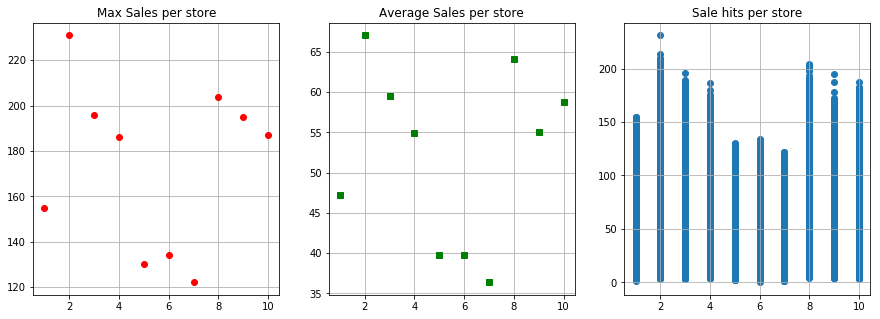

In [35]:
plt.figure(figsize=(15,5)) # (width, height)

plt.subplot(1,3,1) #(row,col,index_in_this_matrix)
store_sales = pd.pivot_table(train, index=['store'], values='sales', aggfunc=[np.max])
plt.title('Max Sales per store')
plt.grid()
plt.plot(store_sales, 'ro')

plt.subplot(1,3,2)
store_sales = pd.pivot_table(train, index=['store'], values='sales', aggfunc=[np.mean])
plt.title('Average Sales per store')
plt.grid()
plt.plot(store_sales, 'gs')

plt.subplot(1,3,3)
plt.title('Sale hits per store')
plt.grid()
plt.scatter(train.store, train.sales)


### Clearly, 2nd store is the topper and 7th store is the least revenue generating one

### 2. Variation in scale of the sale transacted|

In [37]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [38]:
train.sales

0         13
1         11
2         14
3         13
4         10
5         12
6         10
7          9
8         12
9          9
10         9
11         7
12        10
13        12
14         5
15         7
16        16
17         7
18        18
19        15
20         8
21         7
22         9
23         8
24        14
25        12
26        12
27        11
28         6
29         9
          ..
912970    49
912971    75
912972    54
912973    68
912974    60
912975    66
912976    67
912977    69
912978    69
912979    54
912980    67
912981    67
912982    72
912983    72
912984    52
912985    86
912986    53
912987    54
912988    51
912989    63
912990    75
912991    70
912992    76
912993    51
912994    41
912995    63
912996    59
912997    74
912998    62
912999    82
Name: sales, Length: 913000, dtype: int64

/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



AttributeError: Unknown property hitstype

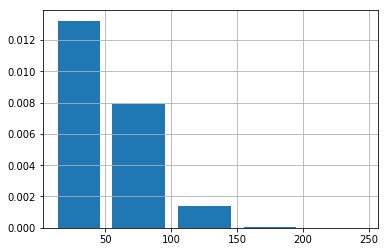

In [41]:
bins = [10, 50, 100, 150, 200, 250]
plt.grid()
plt.hist(train.sales, bins, normed=1, hitstype='bar', rwidth=0.8)

# More insights:

### 1. Store wise total and average sales:

In [45]:
pivot_table_store_sales = pd.pivot_table(train, index=['store'], values='sales', aggfunc=[np.sum, np.mean])
print(pivot_table_store_sales)
print()
print(pivot_table_store_sales.max)




           sum       mean
         sales      sales
store                    
1      4315603  47.268379
2      6120128  67.033165
3      5435144  59.530602
4      5012639  54.902946
5      3631016  39.770164
6      3627670  39.733516
7      3320009  36.363735
8      5856169  64.142048
9      5025976  55.049025
10     5360158  58.709288

<bound method DataFrame.max of            sum       mean
         sales      sales
store                    
1      4315603  47.268379
2      6120128  67.033165
3      5435144  59.530602
4      5012639  54.902946
5      3631016  39.770164
6      3627670  39.733516
7      3320009  36.363735
8      5856169  64.142048
9      5025976  55.049025
10     5360158  58.709288>


<Figure size 1080x720 with 0 Axes>

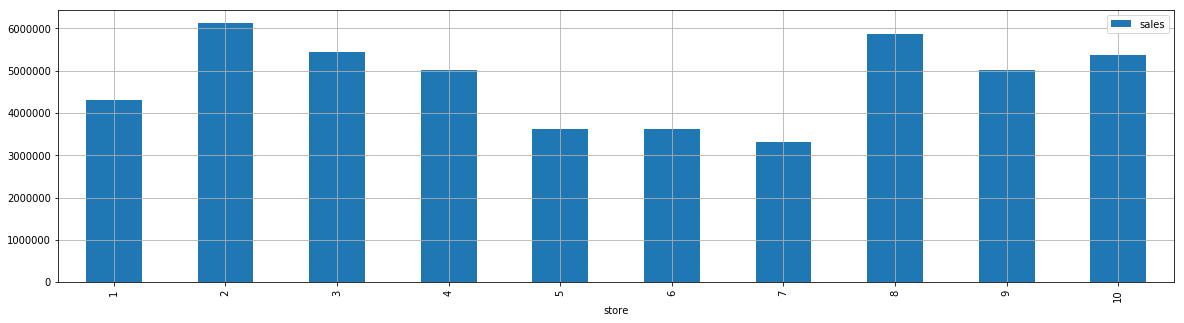

In [48]:
plt.figure(figsize=(15,10)) # (width, height)

pivot_table_store_sales['sum'].plot(kind='bar', legend='Sum', figsize=(20,5)).grid()

### 2. Item wise total and average sales:

          sum       mean
        sales      sales
item                    
1      401384  21.981599
2     1069564  58.574151
3      669087  36.642223
4      401907  22.010241
5      335230  18.358708
6     1068281  58.503888
7     1068777  58.531051
8     1405108  76.950055
9      938379  51.389869
10    1337133  73.227437
11    1271925  69.656353
12    1271534  69.634940
13    1539621  84.316594
14    1071531  58.681873
15    1607442  88.030778
16     468480  25.656079
17     602486  32.994852
18    1538876  84.275794
19     736892  40.355531
20     867641  47.515936
21     736190  40.317087
22    1469971  80.502245
23     534979  29.297864
24    1205975  66.044633
25    1473334  80.686418
26     869981  47.644085
27     402628  22.049726
28    1604713  87.881325
29    1271240  69.618839
30     736554  40.337021
31    1070845  58.644304
32     803107  43.981763
33    1270183  69.560953
34     469935  25.735761
35    1201541  65.801807
36    1406548  77.028916
37     534258  29.258379


<Figure size 1080x720 with 0 Axes>

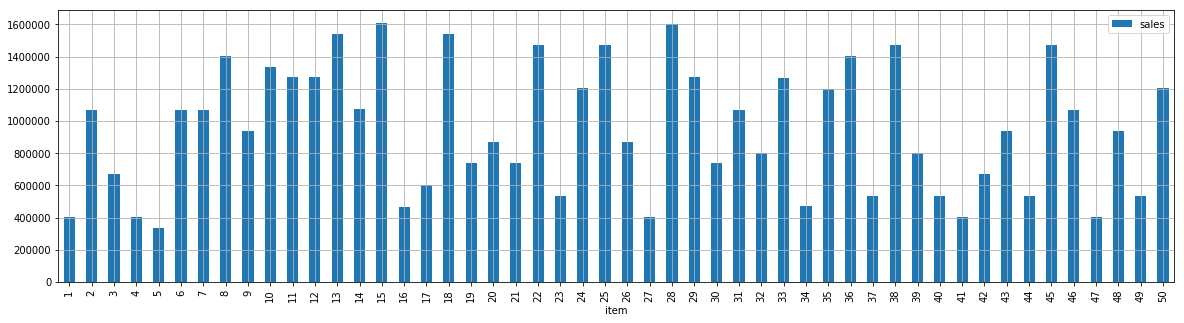

In [49]:
pivot_table_item_sales = pd.pivot_table(train, index=['item'], values='sales', aggfunc=[np.sum, np.mean])
print(pivot_table_item_sales)
print()
print(pivot_table_item_sales.max)

plt.figure(figsize=(15,10)) # (width, height)

pivot_table_item_sales['sum'].plot(kind='bar', legend='Sum', figsize=(20,5)).grid()


### 1. Store's sales performance over time

In [54]:
pivot_table_date_sales = pd.pivot_table(train, index=['date'], values='sales', columns=['store'], aggfunc=[np.sum])
pivot_table_date_sales.head()

sum                                                      
store         1     2     3     4     5     6     7     8     9     10
date                                                                  
2013-01-01  1316  1742  1588  1423  1032  1099   964  1628  1383  1521
2013-01-02  1264  1808  1538  1432   997  1023   944  1687  1455  1530
2013-01-03  1305  1887  1635  1534  1130  1149   966  1736  1492  1654
2013-01-04  1452  1983  1741  1685  1258  1201  1040  1966  1612  1739
2013-01-05  1499  2087  1887  1649  1154  1286  1131  2005  1698  1841

### 2. Item's sales performance over time

In [55]:
pivot_table_date_sales = pd.pivot_table(train, index=['date'], values='sales', columns=['item'], aggfunc=[np.sum])
pivot_table_date_sales.head()

sum                                              ...             \
item         1    2    3    4    5    6    7    8    9    10 ...    41   42   
date                                                         ...              
2013-01-01  133  327  172  102   83  288  278  416  245  378 ...   103  195   
2013-01-02   99  279  213  110   81  310  291  386  225  397 ...   132  215   
2013-01-03  127  304  193  112   96  309  324  398  265  388 ...   131  215   
2013-01-04  145  359  218  138  108  343  335  430  313  462 ...   122  224   
2013-01-05  149  377  217  144  100  343  377  481  319  449 ...   142  243   

                                                    
item         43   44   45   46   47   48   49   50  
date                                                
2013-01-01  253  154  396  319  116  277  159  330  
2013-01-02  255  165  393  316  118  281  159  384  
2013-01-03  306  170  459  325  104  280  187  356  
2013-01-04  323  189  450  351  128  296  184  394  
2013-01-05  309  202  533  360  133  344  179  407  

[5 rows x 50 columns]